In [1]:
%load_ext autoreload
%autoreload

import os
import time
import pickle
from glob import glob
from pathlib import Path

import numpy as np
from omegaconf import OmegaConf
import tensorflow as tf
from neuralDecoder.neuralSequenceDecoder import NeuralSequenceDecoder
import neuralDecoder.utils.lmDecoderUtils as lmDecoderUtils

physical_devices = tf.config.list_physical_devices("GPU")
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
sess_cers = {
    'session': [],
    'rnn_cer_mean': [],
    'lm_cer_mean': [],
    'rnn_wer_mean': [],
    'lm_wer_mean': [],
    'seed': [],
    'train_data': [],
    'test_data': []
}

held_out_sessions = ['2023.04.17', '2023.05.31', '2023.06.28', '2023.08.16', '2023.10.09']



In [3]:

ngram_decoder = lmDecoderUtils.build_lm_decoder(
    '/oak/stanford/groups/henderj/stfan/code/CORP/FalconChallenge/data/language_model',
    acoustic_scale=0.8,
    nbest=10,
)

with tf.device("/gpu:0"):
    gpt2_decoder, gpt2_tokenizer = lmDecoderUtils.build_gpt2(
        'gpt2-xl', 
        cacheDir='/scratch/users/stfan/huggingface/'
    )

llm_acoustic_scale = 0.5
llm_weight = 1.0
blank_penalty = np.log(11)

I0528 20:44:48.124832 20326 brain_speech_decoder.h:52] Reading fst /oak/stanford/groups/henderj/stfan/code/CORP/FalconChallenge/data/language_model/TLG.fst
I0528 20:45:48.265910 20326 brain_speech_decoder.h:81] Reading symbol table /oak/stanford/groups/henderj/stfan/code/CORP/FalconChallenge/data/language_model/words.txt
2024-05-28 20:45:48.981747: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 20:45:49.392152: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38336 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2024-05-28 20:45:56.933119: W tensorflow/python/util/util.cc:368] Sets are

In [4]:
def llm_decode(acoustic_scale, blank_penalty, llm_weight, rnn_outputs, ngram_decoder, gpt2_decoder, gpt2_tokenizer):
    # Generate nbest outputs from 5gram LM
    start_t = time.time()
    nbest_outputs = []
    logits = lmDecoderUtils.rearrange_handwriting_logits(rnn_outputs['logits'])
    logitLengths = rnn_outputs['logitLengths']
    for j in range(len(logits)):
        nbest = lmDecoderUtils.lm_decode(ngram_decoder,
                                        logits[j, :logitLengths[j]],
                                        blankPenalty=blank_penalty,
                                        returnNBest=True,
                                        rescore=False)
        nbest_outputs.append(nbest)
    time_per_sample = (time.time() - start_t) / len(logits)
    print(f'ngram decoding took {time_per_sample} seconds per sample')

    # Rescore nbest outputs with LLM
    start_t = time.time()
    llm_out = lmDecoderUtils.cer_with_gpt2_decoder(gpt2_decoder,
                                                gpt2_tokenizer,
                                                nbest_outputs,
                                                acoustic_scale,
                                                rnn_outputs,
                                                outputType='handwriting',
                                                returnCI=False,
                                                lengthPenalty=0,
                                                alpha=llm_weight)
    time_per_sample = (time.time() - start_t) / len(logits)
    print(f'LLM decoding took {time_per_sample} seconds per sample')

    
    return llm_out

from neuralDecoder.datasets.handwritingDataset import CHAR_DEF
def wer_on_rnn_out(rnn_outputs):
    decoded_seqs = []
    true_seqs = []
    for true_seq, decoded_seq in zip(rnn_outputs['trueSeqs'], rnn_outputs['decodedSeqs']):
        decoded_seq = ''.join([CHAR_DEF[x] for x in decoded_seq if x != -1])
        true_seq = ''.join([CHAR_DEF[x] for x in true_seq if x != -1])
        decoded_seqs.append(decoded_seq)
        true_seqs.append(true_seq)

    _, wer = lmDecoderUtils._cer_and_wer(decoded_seqs, true_seqs)
    return wer

# Model trained on held_in

In [5]:
# Get per session CERs on held_out_eval
for ckptDir in glob('/oak/stanford/groups/henderj/stfan/logs/handwriting_logs/corp_falcon_seed_model_heldin/batch*'):
    for sess in held_out_sessions:
        args = OmegaConf.load(os.path.join(ckptDir, 'args.yaml'))
        args['loadDir'] = ckptDir
        args['mode'] = 'infer'
        args['loadCheckpointIdx'] = None

        args['dataset']['sessions'] = args['dataset']['sessions'] + [sess]
        args['dataset']['datasetToLayerMap'] = args['dataset']['datasetToLayerMap'] + [20]
        args['dataset']['datasetProbabilityVal'] = len(args['dataset']['datasetProbabilityVal']) * [0.0] + [1.0]
        args['dataset']['dataDir'] = args['dataset']['dataDir'] + ['/oak/stanford/groups/henderj/stfan/code/CORP/FalconChallenge/data/held_out_oracle_tfrecords/']


        with tf.device('/gpu:0'):  # Change to GPU:0 to run on GPU
        # Initialize model
            tf.compat.v1.reset_default_graph()
            nsd = NeuralSequenceDecoder(args)

            # Inference
            out = nsd.inference()
            llm_out = llm_decode(llm_acoustic_scale, blank_penalty, llm_weight, out, ngram_decoder, gpt2_decoder, gpt2_tokenizer)
            print(out['cer'], llm_out['wer'])

            sess_cers['session'].append(sess)
            sess_cers['rnn_cer_mean'].append(out['cer'])
            sess_cers['rnn_wer_mean'].append(wer_on_rnn_out(out))
            sess_cers['lm_cer_mean'].append(llm_out['cer'])
            sess_cers['lm_wer_mean'].append(llm_out['wer'])
            sess_cers['seed'].append(args['seed'])
            sess_cers['train_data'].append('held_in_calib')
            sess_cers['test_data'].append('held_out_eval')

# Get average CERs on held_in_eval
for ckptDir in glob('/oak/stanford/groups/henderj/stfan/logs/handwriting_logs/corp_falcon_seed_model_heldin/batch*'):
    args = OmegaConf.load(os.path.join(ckptDir, 'args.yaml'))
    args['loadDir'] = ckptDir
    args['mode'] = 'infer'
    args['loadCheckpointIdx'] = None

    args['dataset']['dataDir'] = len(args['dataset']['dataDir']) * ['/oak/stanford/groups/henderj/stfan/code/CORP/FalconChallenge/data/held_in_eval_tfrecords/']


    with tf.device('/gpu:0'):  # Change to GPU:0 to run on GPU
    # Initialize model
        tf.compat.v1.reset_default_graph()
        
        # Inference
        out = nsd.inference()
        llm_out = llm_decode(llm_acoustic_scale, blank_penalty, llm_weight, out, ngram_decoder, gpt2_decoder, gpt2_tokenizer)
        print(out['cer'], llm_out['wer'])

        sess_cers['session'].append('all_held_in_sessions')
        sess_cers['rnn_cer_mean'].append(out['cer'])
        sess_cers['rnn_wer_mean'].append(wer_on_rnn_out(out))
        sess_cers['lm_cer_mean'].append(llm_out['cer'])
        sess_cers['lm_wer_mean'].append(llm_out['wer'])
        sess_cers['seed'].append(args['seed'])
        sess_cers['train_data'].append('held_in_calib')
        sess_cers['test_data'].append('held_in_eval')


Model: "gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 multiple                  1084416   
                                                                 
 gru_2 (GRU)                 multiple                  1575936   
                                                                 
 dense (Dense)               multiple                  16416     
                                                                 
Total params: 2,677,280
Trainable params: 2,677,280
Non-trainable params: 0
_________________________________________________________________
Loading from : /oak/stanford/groups/henderj/stfan/logs/handwriting_logs/corp_falcon_seed_model_heldin/batchSize=48,batchesPerVal=500,dataset=falcon_seed_sessions,model=gru_stack_handwriting,nBatchesToTrain=20000,seed=2/ckpt-14000


2024-05-28 20:46:09.403047: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8600


ngram decoding took 0.5802246332168579 seconds per sample
LLM decoding took 0.31555749475955963 seconds per sample
0.28225806451612906 0.25
Model: "gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 multiple                  1084416   
                                                                 
 gru_2 (GRU)                 multiple                  1575936   
                                                                 
 dense (Dense)               multiple                  16416     
                                                                 
Total params: 2,677,280
Trainable params: 2,677,280
Non-trainable params: 0
_________________________________________________________________
Loading from : /oak/stanford/groups/henderj/stfan/logs/handwriting_logs/corp_falcon_seed_model_heldin/batchSize=48,batchesPerVal=500,dataset=falcon_seed_sessions,model=gru_stack

# Model trained on held_out_oracle

In [6]:
# Get per session CERs for held_out
for i in range(1, 6):
    for ckptDir in glob(f'/oak/stanford/groups/henderj/stfan/logs/handwriting_logs/falcon_held_out_oracle_sessions/batch*session{i}*'):
        args = OmegaConf.load(os.path.join(ckptDir, 'args.yaml'))
        args['loadDir'] = ckptDir
        args['mode'] = 'infer'
        args['loadCheckpointIdx'] = None

        n_sessions = len(args['dataset']['sessions'])
        args['dataset']['datasetProbabilityVal'] = [0] * (n_sessions - 1) + [1]

        with tf.device('/GPU:0'):  # Change to GPU:0 to run on GPU
        # Initialize model
            tf.compat.v1.reset_default_graph()
            nsd = NeuralSequenceDecoder(args)

            # Inference
            out = nsd.inference()
            llm_out = llm_decode(llm_acoustic_scale, blank_penalty, llm_weight, out, ngram_decoder, gpt2_decoder, gpt2_tokenizer)

            sess_cers['session'].append(held_out_sessions[i - 1])
            sess_cers['rnn_cer_mean'].append(out['cer'])
            sess_cers['rnn_wer_mean'].append(wer_on_rnn_out(out))
            sess_cers['lm_cer_mean'].append(llm_out['cer'])
            sess_cers['lm_wer_mean'].append(llm_out['wer'])
            sess_cers['seed'].append(args['seed'])
            sess_cers['train_data'].append('held_in_calib+held_out_oracle')
            sess_cers['test_data'].append('held_out_eval')


Model: "gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 multiple                  1084416   
                                                                 
 gru_2 (GRU)                 multiple                  1575936   
                                                                 
 dense (Dense)               multiple                  16416     
                                                                 
Total params: 2,677,280
Trainable params: 2,677,280
Non-trainable params: 0
_________________________________________________________________
Loading from : /oak/stanford/groups/henderj/stfan/logs/handwriting_logs/falcon_held_out_oracle_sessions/batchSize=48,batchesPerVal=500,dataset=falcon_held_out_oracle_session1,model=gru_stack_handwriting,nBatchesToTrain=20000,seed=4/ckpt-9000
ngram decoding took 0.1677550971508026 seconds per sample
LLM decoding took

# Fine-tuned models

In [7]:
for i in range(1, 6):
    for ckptDir in glob(f'/oak/stanford/groups/henderj/stfan/logs/handwriting_logs/falcon_held_out_few_shot/batch*session{i}*'):
        args = OmegaConf.load(os.path.join(ckptDir, 'args.yaml'))
        args['loadDir'] = ckptDir
        args['mode'] = 'infer'
        args['loadCheckpointIdx'] = None

        with tf.device('/gpu:0'):  # Change to GPU:0 to run on GPU
        # Initialize model
            tf.compat.v1.reset_default_graph()
            nsd = NeuralSequenceDecoder(args)

            # Inference
            out = nsd.inference()
            llm_out = llm_decode(llm_acoustic_scale, blank_penalty, llm_weight, out, ngram_decoder, gpt2_decoder, gpt2_tokenizer)

            print(out['cer'])
            sess_cers['session'].append(held_out_sessions[i-1])
            sess_cers['rnn_cer_mean'].append(out['cer'])
            sess_cers['rnn_wer_mean'].append(wer_on_rnn_out(out))
            sess_cers['lm_cer_mean'].append(llm_out['cer'])
            sess_cers['lm_wer_mean'].append(llm_out['wer'])
            sess_cers['seed'].append(args['seed'])
            sess_cers['train_data'].append('held_in_calib+held_out_calib')
            sess_cers['test_data'].append('held_out_eval')

Model: "gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 multiple                  1084416   
                                                                 
 gru_2 (GRU)                 multiple                  1575936   
                                                                 
 dense (Dense)               multiple                  16416     
                                                                 
Total params: 2,677,280
Trainable params: 2,677,280
Non-trainable params: 0
_________________________________________________________________
Loading from : /oak/stanford/groups/henderj/stfan/logs/handwriting_logs/falcon_held_out_few_shot/batchSize=48,batchesPerSave=50,batchesPerVal=50,dataset=falcon_held_out_session1,model=gru_stack_handwriting,nBatchesToTrain=500,seed=4/ckpt-500
ngram decoding took 0.26378530263900757 seconds per sample
LLM decoding too

In [8]:
import re

def _convert(s):
    s = s.replace(">", " ")
    s = s.replace("#", "")
    s = re.sub(r"([~,!?])", r" \1", s)
    return s

for seed in range(1, 6):
    with open(f'/oak/stanford/groups/henderj/stfan/code/CORP/FalconChallenge/data/corp_held_out_eval_seed_{seed}.pkl', 'rb') as f:
        data = pickle.load(f)

    decoded = data['decoded']
    gt = data['gt']
    for sess_id in range(5):
        sess_start_idx = sess_id * 16
        sess_end_idx = sess_start_idx + 16
        hyps = decoded[sess_start_idx:sess_end_idx]
        refs = gt[sess_start_idx:sess_end_idx]
    
        hyps = [_convert(s) for s in hyps]
        refs = [_convert(s) for s in refs]
        cer, wer = lmDecoderUtils._cer_and_wer(hyps, refs)

        sess_cers['session'].append(held_out_sessions[sess_id])
        sess_cers['rnn_cer_mean'].append(np.nan)
        sess_cers['rnn_wer_mean'].append(np.nan)
        sess_cers['lm_cer_mean'].append(cer)
        sess_cers['lm_wer_mean'].append(wer)
        sess_cers['seed'].append(seed)
        sess_cers['train_data'].append('held_in_calib+held_out_eval(CORP)')
        sess_cers['test_data'].append('held_out_eval')


In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sess_cers_df = pd.DataFrame(sess_cers)
sess_cers_df.to_csv('/oak/stanford/groups/henderj/stfan/code/CORP/FalconChallenge/data/model_eval.csv')
pd.read_csv

<function pandas.io.parsers.readers.read_csv(filepath_or_buffer: 'FilePath | ReadCsvBuffer[bytes] | ReadCsvBuffer[str]', *, sep: 'str | None | lib.NoDefault' = <no_default>, delimiter: 'str | None | lib.NoDefault' = None, header: "int | Sequence[int] | None | Literal['infer']" = 'infer', names: 'Sequence[Hashable] | None | lib.NoDefault' = <no_default>, index_col: 'IndexLabel | Literal[False] | None' = None, usecols=None, dtype: 'DtypeArg | None' = None, engine: 'CSVEngine | None' = None, converters=None, true_values=None, false_values=None, skipinitialspace: 'bool' = False, skiprows=None, skipfooter: 'int' = 0, nrows: 'int | None' = None, na_values=None, keep_default_na: 'bool' = True, na_filter: 'bool' = True, verbose: 'bool' = False, skip_blank_lines: 'bool' = True, parse_dates: 'bool | Sequence[Hashable] | None' = None, infer_datetime_format: 'bool | lib.NoDefault' = <no_default>, keep_date_col: 'bool' = False, date_parser=<no_default>, date_format: 'str | None' = None, dayfirst: '

In [10]:
for train_data in sess_cers_df['train_data'].unique():
    selected_rows = sess_cers_df.loc[(sess_cers_df['test_data'] == 'held_out_eval') & (sess_cers_df['train_data'] == train_data)].groupby('seed')
    mean_rnn_cer = np.mean(selected_rows['rnn_cer_mean'].mean())
    mean_rnn_wer = np.mean(selected_rows['rnn_wer_mean'].mean())
    mean_lm_cer = np.mean(selected_rows['lm_cer_mean'].mean())
    mean_lm_wer = np.mean(selected_rows['lm_wer_mean'].mean())
    print(f'{train_data}: RNN CER: {mean_rnn_cer:.2f}, RNN WER: {mean_rnn_wer:.2f}, LM CER: {mean_lm_cer:.2f}, LM WER: {mean_lm_wer:.2f}')

held_in_calib: RNN CER: 0.36, RNN WER: 0.53, LM CER: 0.23, LM WER: 0.37
held_in_calib+held_out_oracle: RNN CER: 0.06, RNN WER: 0.15, LM CER: 0.01, LM WER: 0.03
held_in_calib+held_out_calib: RNN CER: 0.22, RNN WER: 0.40, LM CER: 0.08, LM WER: 0.16
held_in_calib+held_out_eval(CORP): RNN CER: nan, RNN WER: nan, LM CER: 0.06, LM WER: 0.11


In [11]:
print(sess_cers_df['train_data'].unique())
print(sess_cers_df['test_data'].unique())

['held_in_calib' 'held_in_calib+held_out_oracle'
 'held_in_calib+held_out_calib' 'held_in_calib+held_out_eval(CORP)']
['held_out_eval' 'held_in_eval']


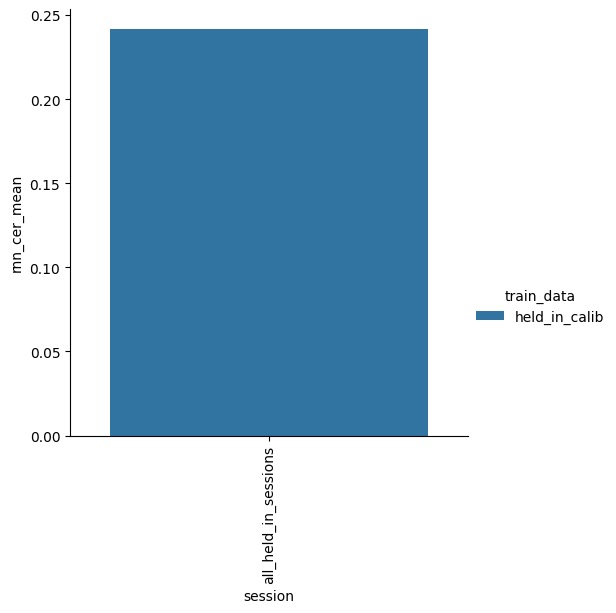

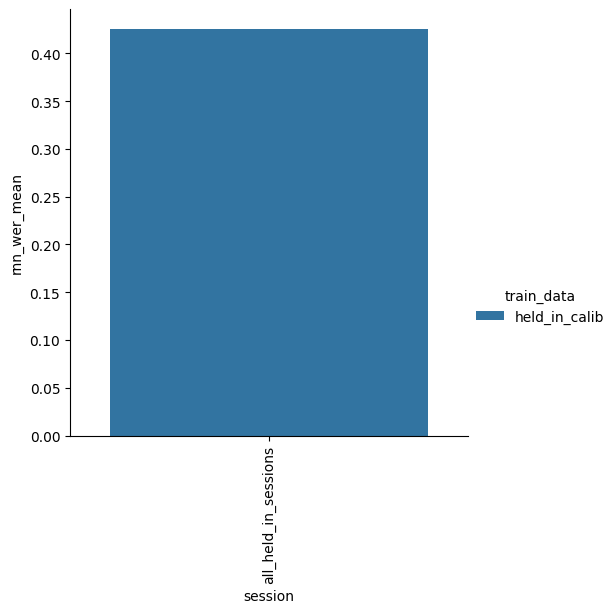

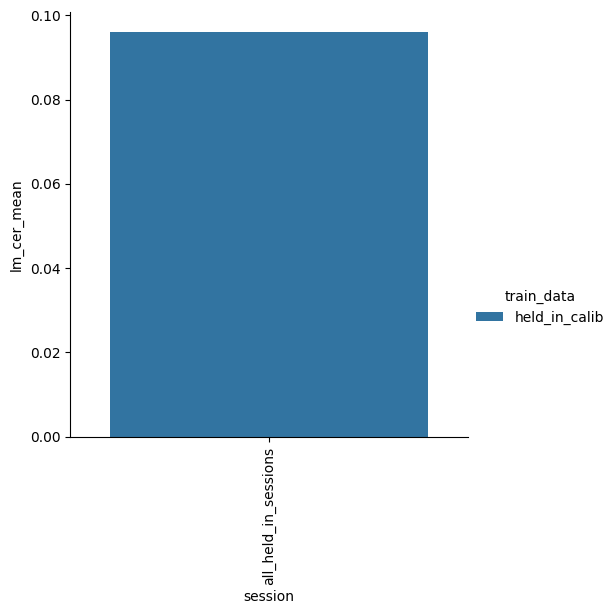

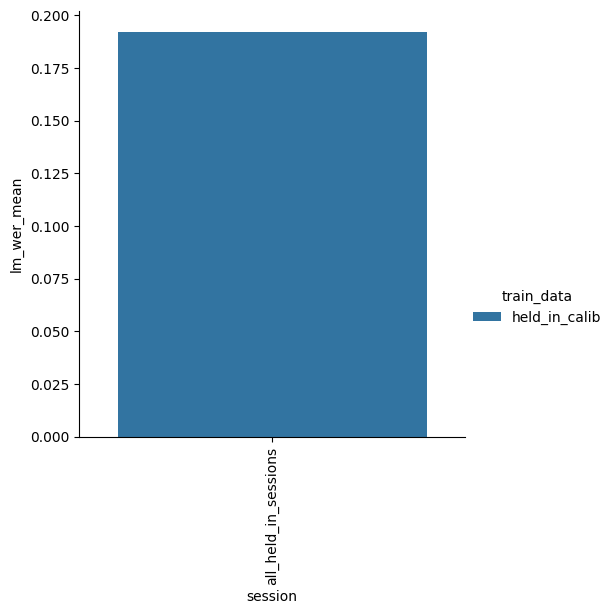

In [12]:
sns.catplot(data=sess_cers_df[sess_cers_df['test_data'] == 'held_in_eval'], 
            x='session', 
            y='rnn_cer_mean', 
            hue='train_data', 
            kind='bar')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.show()

sns.catplot(data=sess_cers_df[sess_cers_df['test_data'] == 'held_in_eval'], 
            x='session', 
            y='rnn_wer_mean', 
            hue='train_data', 
            kind='bar')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.show()

sns.catplot(data=sess_cers_df[sess_cers_df['test_data'] == 'held_in_eval'], 
            x='session', 
            y='lm_cer_mean', 
            hue='train_data', 
            kind='bar')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.show()

sns.catplot(data=sess_cers_df[sess_cers_df['test_data'] == 'held_in_eval'], 
            x='session', 
            y='lm_wer_mean', 
            hue='train_data', 
            kind='bar')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.show()

/home/groups/henderj/stfan/.conda/env/corp/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/groups/henderj/stfan/.conda/env/corp/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


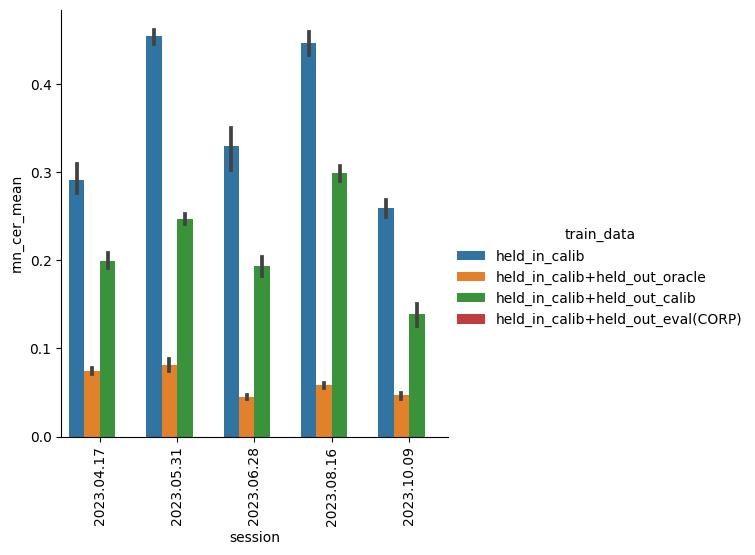

/home/groups/henderj/stfan/.conda/env/corp/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/groups/henderj/stfan/.conda/env/corp/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


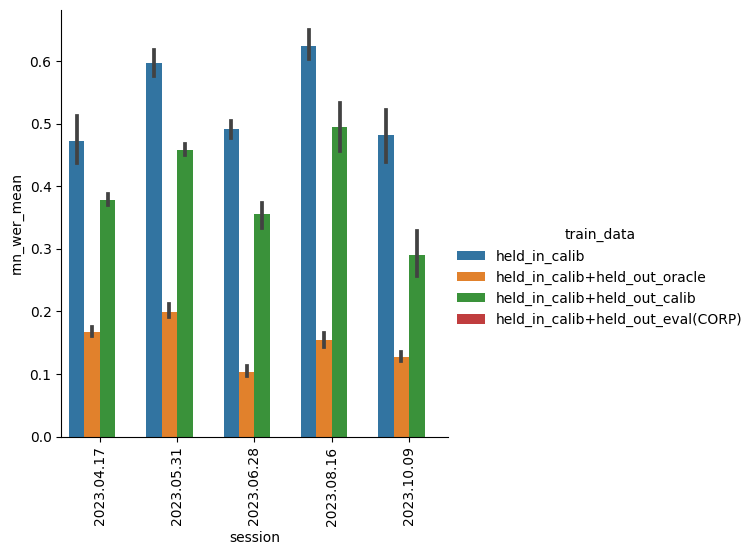

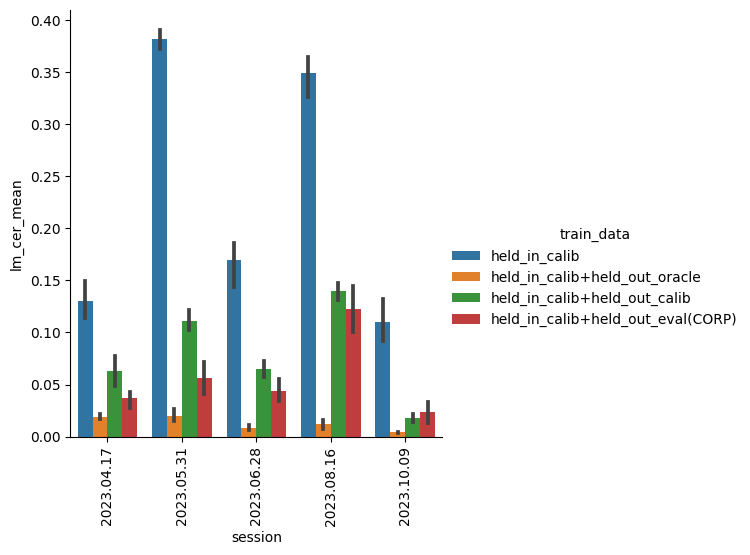

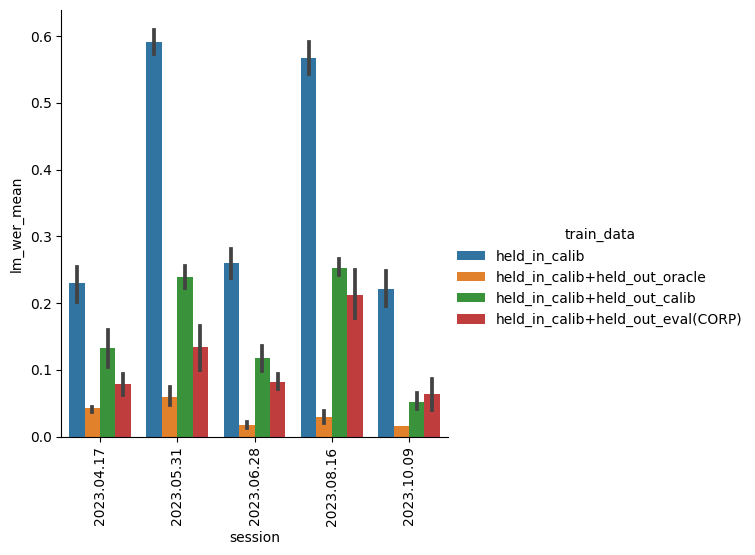

In [13]:
sns.catplot(data=sess_cers_df[sess_cers_df['test_data'] == 'held_out_eval'], 
            x='session', 
            y='rnn_cer_mean', 
            hue='train_data', 
            kind='bar')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.show()

sns.catplot(data=sess_cers_df[sess_cers_df['test_data'] == 'held_out_eval'], 
            x='session', 
            y='rnn_wer_mean', 
            hue='train_data', 
            kind='bar')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.show()

sns.catplot(data=sess_cers_df[sess_cers_df['test_data'] == 'held_out_eval'], 
            x='session', 
            y='lm_cer_mean', 
            hue='train_data', 
            kind='bar')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.show()

sns.catplot(data=sess_cers_df[sess_cers_df['test_data'] == 'held_out_eval'], 
            x='session', 
            y='lm_wer_mean', 
            hue='train_data', 
            kind='bar')
plt.xticks(rotation=90)  # Rotate x-axis labels by 90 degrees
plt.show()


In [14]:
# Run CORP on held_out_oracle and held_out_eval, and compare the results on held_out_eval, this should be better than held_out_zero_shot_eval